In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import ipywidgets as widgets
import time
from scipy import linalg
from scipy import optimize
import sympy as sm
import pandas as pd

sm.init_printing(use_unicode=True)

In [19]:
mu_t = sm.symbols("mu_t")
mu_t1 = sm.symbols("mu_t-1")
b_t = sm.symbols("b_t")
a_t = sm.symbols("a_t")
p_t = sm.symbols("P_t")
v = sm.symbols("v")
v_h = sm.symbols("v^H")
v_l = sm.symbols("v^L")
d_t = sm.symbols("d_t")
sd_t = sm.symbols("s(d_t)")
s_a = sm.symbols("s_t^a")
s_b = sm.symbols("s_t^b")
theta_t = sm.symbols("theta_t")
theta_t1 = sm.symbols("theta_t-1")
pi = sm.symbols("pi")
beta_b = sm.symbols("beta_B")
beta_s = sm.symbols("beta_S")
spib = sm.symbols("Pi_buy")
spis = sm.symbols("Pi_sell")


In [20]:
minimering = abs(v-p_t)
p_t = mu_t = mu_t1 + sd_t * d_t
a_t = mu_t1 + s_a
b_t = mu_t1 + s_b
s_a = (pi*theta_t1*(1-theta_t1))/(pi*theta_t1+(1-pi)*beta_b)*(v_h-v_l)
s_b = (pi*(1-theta_t1)*(1-theta_t1))/(pi*theta_t1+(1-pi)*beta_s)*(v_h-v_l)
spib = theta_t1*pi*(a_t-v_h)+beta_b*(1-pi)*(a_t-mu_t1)
spis = (1-theta_t1)*pi*(v_l-b_t)+beta_s*(1-pi)*(mu_t1-b_t)


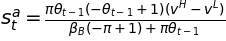

In [21]:
sm.Eq(sm.symbols("s_t^a"), s_a)

In [22]:
p_t

draw.io

In [116]:
def simulation(vh=1, vl=0, decision="v_h", ratio=0.2, uninformed=0.5, startvalue=0.5, iterations = 500, seed=5000, epsilon=10**-5, shockperiod = None, shock={}):
    #define constants
    v_h = vh
    v_l = vl
    pi = ratio
    beta_b = uninformed
    beta_s = 1-beta_b
    shock = shock
    
    #determine realized value of v
    v = decision
    
    #allocate space
    values=[]
    ratiovalues = []
    iteration = []
    thetavalues = np.empty(iterations)
    muvalues = np.empty(iterations)
    askvalues = np.empty(iterations)
    bidvalues = np.empty(iterations)
    gapvalues = np.empty(iterations)
    pivalues = np.empty(iterations)
    decisionvalues = np.empty(iterations)
    
    #simulation settings
    thetavalues[0]=startvalue
    theta_t1 = startvalue
    N = iterations
    np.random.seed(seed)
    
    break_index = 0
    
    for i in range(N):
        if v=="v_h":
            v=v_h
        elif v=="v_l":
            v=v_l
            
        if i==shockperiod:
            if shock != {}:
                if "Private" in shock:
                    if shock["Private"]==1:
                        v="v_h"
                    if shock["Private"]==0:
                        v="v_l"
                        
                if "Public" in shock:
                    v_l, v_h = shock["Public"]

        mu_t1 = theta_t1*v_h+(1-theta_t1)*v_l
        muvalues[i] = mu_t1
        
        #calculate markup/discount
        s_a = (pi*theta_t1*(1-theta_t1))/(pi*theta_t1+(1-pi)*beta_b)*(v_h-v_l)
        s_b = (pi*theta_t1*(1-theta_t1))/(pi*(1-theta_t1)+(1-pi)*beta_s)*(v_h-v_l)
        
        #calculate ask/bid price
        askvalues[i] = a_t = mu_t1 + s_a
        bidvalues[i] = b_t = mu_t1 - s_b 
        
        #calculate gap
        gapvalues[i] = gap_t = a_t - b_t
        
        #realize pi
        pivalues[i] = trader = np.random.binomial(1,pi)
        
        #if trader is informed
        if trader == 1:
            if v == v_h:
                if v_h>a_t:
                    d_t=1
            if v == v_l:
                if v_l<b_t:
                    d_t=-1
                    
        #if trader is uninformed
        if trader == 0:
            buysell = np.random.binomial(1,beta_b)
            if buysell == 1:
                d_t = 1
            else:
                d_t = -1
        
        decisionvalues[i] = d_t
        
        #update theta
        if d_t == 1:
            theta_t = ((1+pi)*beta_b)/(pi*theta_t1+(1-pi)*beta_b)*theta_t1
            theta_t1 = theta_t
        if d_t == -1:
            theta_t = ((1-pi)*beta_b)/(pi*(1-theta_t1)+(1-pi)*beta_b)*theta_t1
            theta_t1 = theta_t
        
        if i<iterations-1:
            thetavalues[i+1] = theta_t
        ratiovalues.append(str(ratio))
        iteration.append(int(i))
        
        #off by one error
        break_index=i+1
        if gap_t<epsilon or i == N-1:
            values.extend(["Theta: "+str(theta_t), "Bid: "+str(b_t), "Ask: "+str(a_t), "Mu: "+str(mu_t1)])
            break
            
    
    dataframe = pd.DataFrame()
    dataframe["Iteration"]=iteration
    dataframe["ratio"] = ratiovalues
    dataframe["theta"] = thetavalues[0:break_index]
    dataframe["mu"] = muvalues[0:break_index]
    dataframe["ask"] = askvalues[0:break_index]
    dataframe["bid"] = bidvalues[0:break_index]
    dataframe["spread"] = gapvalues[0:break_index]
    dataframe["trader"] = pivalues[0:break_index]
    dataframe["order"] = decisionvalues[0:break_index]
    
    return dataframe, values

In [117]:
run1 = simulation(ratio=0.15, iterations=1001,seed=404, shockperiod = 90, shock={"Private": 1, "Public": (0.5, 0.7)})
run2 = simulation(ratio=0.1501, iterations=1001,seed=404, shockperiod = 90, shock={"Private": 0})
run3 = simulation(ratio=0.1502, iterations=1001, seed=404, shockperiod = 90, shock={"Private": 0,"Public": (0.5, 0.7)})
run4 = simulation(ratio=0.5, iterations=201, seed=404)
run5 = simulation(ratio=0.9, iterations=201, seed=404)

dataframe1, values1 = run1
dataframe2, values2 = run2
dataframe3, values3 = run3
dataframe4, values4 = run4
dataframe5, values5 = run5

merged = pd.concat([dataframe1,dataframe2,dataframe3,dataframe4,dataframe5])

In [118]:
print(values1,values2,values3)

['Theta: 0.9999148241152956', 'Bid: 0.6999829648230592', 'Ask: 0.6999906930881101', 'Mu: 0.6999874085024806'] ['Theta: 1.018638663218169e-05', 'Bid: 1.0186386632181688e-05', 'Ask: 1.865314333398436e-05', 'Mu: 1.3784352410597332e-05'] ['Theta: 4.591039783417812e-05', 'Bid: 0.5000091820795668', 'Ask: 0.5000168204549132', 'Mu: 0.500012427696542']


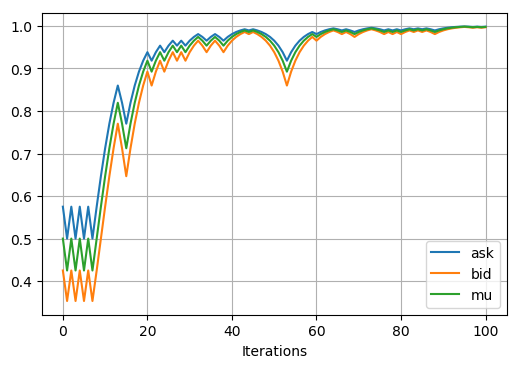

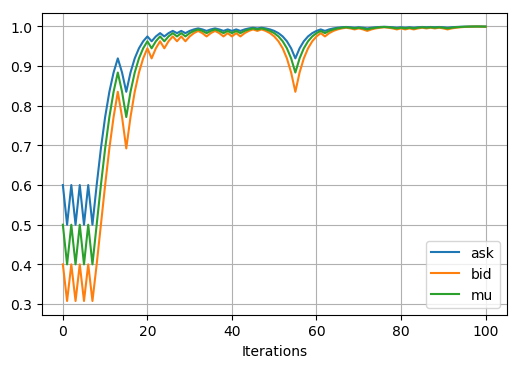

In [5]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1,1,1)
ax.plot(dataframe1["ask"])
ax.plot(dataframe1["bid"])
ax.plot(dataframe1["mu"])
ax.grid(True)
ax.set_xlabel("Iterations")
ax.legend()

fig1 = plt.figure(dpi=100)
ax1 = fig1.add_subplot(1,1,1)
ax1.plot(dataframe2["ask"])
ax1.plot(dataframe2["bid"])
ax1.plot(dataframe2["mu"])
ax1.grid(True)
ax1.set_xlabel("Iterations")
ax1.legend()

In [12]:
run6 = simulation(ratio=0.15, iterations=201,seed=4795)
run7 = simulation(ratio=0.15, iterations=201,seed=6279)
run8 = simulation(ratio=0.15, iterations=201,seed=6130)
run9 = simulation(ratio=0.15, iterations=201,seed=9352)
run10 = simulation(ratio=0.15, iterations=201,seed=5059)

dataframe6, values6 = run6
dataframe7, values7 = run7
dataframe8, values8 = run8
dataframe9, values9 = run9
dataframe10, values10 = run10

Text(0.5, 1.0, 'Theta')

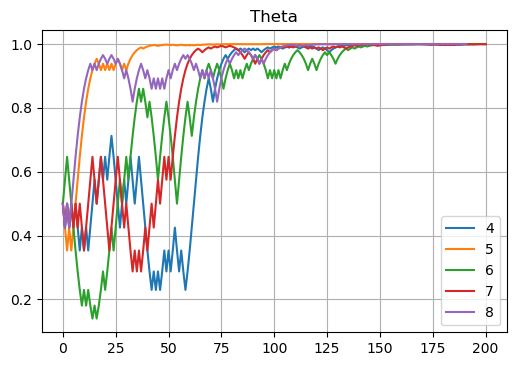

In [15]:
fig = plt.figure(dpi=100)
ax2 = fig.add_subplot(1,1,1)
ax2.plot(dataframe6["theta"], label="6")
ax2.plot(dataframe7["theta"], label="7")
ax2.plot(dataframe8["theta"], label="8")
ax2.plot(dataframe9["theta"], label="9")
ax2.plot(dataframe10["theta"], label="10")
ax2.grid(True)
ax2.legend()
ax2.set_title("Theta")

In [22]:
from plotter import PlotterWindow

In [119]:
graphwindow = PlotterWindow(data = merged, slicename = "ratio", xvariable = "Iteration", yvariablelist = ["mu","ask","bid"], lineplots=True)
graphwindow.start()

In [9]:
merged.head(20)

,Iteration,ratio,theta,mu,ask,bid,spread,trader,order
0,0,0.15,0.500000,0.500000,0.575000,0.425000,0.150000,0.0,-1.0
1,1,0.15,0.425000,0.425000,0.500000,0.353301,0.146699,1.0,1.0
2,2,0.15,0.500000,0.500000,0.575000,0.425000,0.150000,0.0,-1.0
3,3,0.15,0.425000,0.425000,0.500000,0.353301,0.146699,1.0,1.0
4,4,0.15,0.500000,0.500000,0.575000,0.425000,0.150000,0.0,-1.0
5,5,0.15,0.425000,0.425000,0.500000,0.353301,0.146699,0.0,1.0
6,6,0.15,0.500000,0.500000,0.575000,0.425000,0.150000,0.0,-1.0
7,7,0.15,0.425000,0.425000,0.500000,0.353301,0.146699,0.0,1.0
8,8,0.15,0.500000,0.500000,0.575000,0.425000,0.150000,0.0,1.0
9,9,0.15,0.575000,0.575000,0.646699,0.500000,0.146699,0.0,1.0


In [9]:
from mpl_finance import candlestick_ochl

ModuleNotFoundError: No module named 'mpl_finance'

([<matplotlib.lines.Line2D at 0x269061158d0>,
  <matplotlib.patches.Rectangle at 0x26906248a90>])

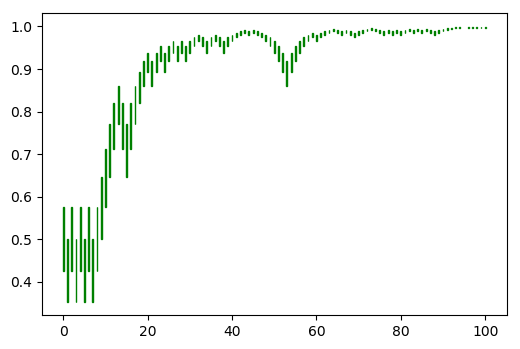

In [23]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1,1,1)

lower = 0
upper = len(list(dataframe1["bid"]))
ochl = []

iteration = list(dataframe1["Iteration"])
bid = list(dataframe1["bid"])
ask = list(dataframe1["ask"])

for lower in range(upper):
    append = iteration[lower], bid[lower], ask[lower], ask[lower], bid[lower]
    ochl.append(append)
candlestick_ochl(ax, ochl, colorup="g",colordown="r")                                                

In [14]:
candlestick_ochl(ax, ochl)

NameError: name 'candlestick_ochl' is not defined

In [7]:
len(list(dataframe1["bid"]))

KeyboardInterrupt: 